In [2]:
# Project imports #
import pandas as pd
import numpy as np
import psycopg2 as pg2
import matplotlib.pyplot as plt
import json
import csv
import re
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from datetime import datetime
import calendar
from calendar import monthrange
# Matplotlib settings #
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

# Extension of Project - Extension 2
#### Objective: To see how labor demand has changed among different occupational groups based on the job ads available on platsbanken between 2008-2020 (shorter time span due to data restrictions)

#### Project outline
- Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
- Step 2: Inserting data into a PostgreSQL database and setting up a query
- Step 3: Visualization and discussion of results
- Concluding remarks

### Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
#### All job ads data used in this project is from [JobTechDev](https://jobtechdev.se/en/docs/apis/historical/), an initiative by the Swedish public employment service.

- Variables to be extracted for this project are the following:
    - **headline**: The ad headline.
    - **number_of_vacancies**: The number of advertised jobs for a given ad, a majority only advertise 1 job (5M out of 6.4M ads).
    - **publication_date**: Date the ad was published on Platsbanken, the job ad platform.
    - **application_deadline**: The last date to apply for the job.
    - **last_publication_date**: The last date the ad was public, used as substitutet for application_deadline for 2017 where application_deadline is missing.
    - **occupation_group**: Occupation group on the 4th level of SSYK. This is the most specific level of SSYK which can easily be aggregated to the more general levels of 3, 2 and 1, level 1 containing the most broad definitions of occupational groups.

In [3]:
total_valid = 0; total_errors = 0
for file in range(2006,2021):
    with open(f'/Users/Kevin/Desktop/project_dta/new_pb_2006_2020/{file}.json') as f:
        ads = json.load(f)
        file_ads = []
        error_rows = 0
        
    # For 2017 application_deadline is null, last_publication_date used as a proxy, vars 99.8% equivalent #
    for ad in ads:
        # Removal of special characters using regex, events of \n causes errors in csv file #
        head_line = re.sub('[!,*)@#%(&$_?.^\\\\\n/]', '', str(ad['headline']))
        if file != 2017:
            try: 
        # Slicing of date variables is to ensure only dates of the format 'yyyy-mm-dd' are included, no time data needed #
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['application_deadline'][:10], int(ad['occupation_group']['legacy_ams_taxonomy_id'])]
            except:
                error_rows += 1
                continue
        else:
            try:
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['last_publication_date'][:10], int(ad['occupation_group']['legacy_ams_taxonomy_id'])]
            except:
                error_rows += 1
                continue
                
        # Jobs ads with no vacancies (=0) or missing values (None) in dates or vacancies are removed using all() #
        if all(ad_select[1:]):
            file_ads.append(ad_select)
        else:
            error_rows += 1
            continue
    # We write the extracted data to a csv file for easy insertion into PostgreSQL #             
    with open(f'/Users/Kevin/Desktop/project_dta/extension_2/{file}_occupation.csv', mode='w', newline="") as file_writer:
        write = csv.writer(file_writer)
        for row in file_ads:
            write.writerow(row)
    print(f'valid ads for {file}: ' + str(len(file_ads)), ' | ', f'erroneous ads for {file}: ' + str(error_rows))
    total_valid += len(file_ads); total_errors += error_rows
print('\n')
print('total valid ads: ' + str(total_valid), '  |  ', 'total erroneous ads: '+ str(total_errors))

valid ads for 2006: 26  |  erroneous ads for 2006: 245201
valid ads for 2007: 34240  |  erroneous ads for 2007: 249865
valid ads for 2008: 182287  |  erroneous ads for 2008: 82936
valid ads for 2009: 141013  |  erroneous ads for 2009: 55111
valid ads for 2010: 218455  |  erroneous ads for 2010: 70799
valid ads for 2011: 304293  |  erroneous ads for 2011: 60395
valid ads for 2012: 318287  |  erroneous ads for 2012: 61071
valid ads for 2013: 325277  |  erroneous ads for 2013: 64776
valid ads for 2014: 397573  |  erroneous ads for 2014: 54412
valid ads for 2015: 583662  |  erroneous ads for 2015: 29851
valid ads for 2016: 700419  |  erroneous ads for 2016: 17627
valid ads for 2017: 702792  |  erroneous ads for 2017: 12499
valid ads for 2018: 681694  |  erroneous ads for 2018: 1275
valid ads for 2019: 639418  |  erroneous ads for 2019: 839
valid ads for 2020: 490512  |  erroneous ads for 2020: 201


total valid ads: 5719948   |   total erroneous ads: 1006858


- In the output above we see that for 2006-2007 there are very few ads left after the filtering process. Because of this, the time span of this extension will be limited to 2008-2020. This is partly attributed to SSYK codes changing over time and changes in data quality.

### Step 2: Inserting data into a postgreSQL database and setting up relevant query
 - For efficient analysis and storage of the dataset we import the data into PostgreSQL.

In [76]:
# DB created in pgAdmin4 GUI, login and connect cursor #
conn = pg2.connect(database='job_ads', user='postgres', password='***********')
cur = conn.cursor()

In [77]:
# Table creation # 
# If data cleaning method in previous step missed any invalid ads, NOT NULL ascertains that no invalid ads are included #
cur.execute("""
CREATE TABLE historic_ads_extension_2(
    ad_id SERIAL PRIMARY KEY,
    headline VARCHAR,
    number_of_vacancies INTEGER NOT NULL,
    publication_date DATE NOT NULL,
    application_deadline DATE NOT NULL,
    occupation_group INTEGER NOT NULL)
    ;""")
conn.commit()

In [78]:
# Loading in SSYK levels for join #   
cur.execute(f"""
CREATE TABLE ssyk(
    ssyk_code_1 INTEGER NOT NULL,
    ssyk_desc_1 VARCHAR NOT NULL,
    ssyk_code_2 INTEGER NOT NULL,
    ssyk_desc_2 VARCHAR NOT NULL,
    ssyk_code_4 INTEGER NOT NULL,
    ssyk_desc_4 VARCHAR NOT NULL)
    ;""")
conn.commit()

In [79]:
# Importing csv files into PostgreSQL #
for file in range(2006, 2021):
    with open(f'/Users/Kevin/Desktop/project_dta/extension_2/{file}_occupation.csv', 'r') as csv_file:
        cur.copy_from(csv_file, 'historic_ads_extension_2', sep=',', columns=('headline', 'number_of_vacancies', 'publication_date', 'application_deadline', 'occupation_group'))
    conn.commit()

# Importing SSYK #
with open('/Users/Kevin/Desktop/project_dta/extension_2/ssyk_levels/ssyk_merged.csv', 'r') as csv_file:
    cur.copy_from(csv_file, 'ssyk', sep=';', columns=('ssyk_code_1', 'ssyk_desc_1', 'ssyk_code_2', 'ssyk_desc_2', 'ssyk_code_4', 'ssyk_desc_4'))
    conn.commit()

* In the data, occupational group data is mixed between the 3rd and 4th level of SSYK. As such, SSYK codes for the 3rd and 4th level are connected and combined before it is loaded into the ssyk table (for details on how this is done, look at the extra_code file in repo).
* Below we enrich our ads with all levels of SSYK. We can now perform analysis based on the specific occupational group of our liking.

In [80]:
# Full inner join #
cur.execute("""
    CREATE TABLE historic_ads_2 AS 
    (SELECT ad_id, headline, number_of_vacancies, publication_date, application_deadline, occupation_group, ssyk.ssyk_code_1, ssyk.ssyk_desc_1, ssyk.ssyk_code_2, ssyk.ssyk_desc_2, ssyk.ssyk_code_4, ssyk.ssyk_desc_4
    FROM historic_ads_extension_2
    INNER JOIN ssyk
    ON historic_ads_extension_2.occupation_group = ssyk.ssyk_code_4);
    ;""")
conn.commit()

#### SSYK Level 1 

In [96]:
# Base dictionary for each day, if any vacancies exist for the given occupational group the given day, the value is added #
set_up = {'Date':'', 'Chefsyrken':0 , 'Militära yrken': 0, 'Service-, omsorgs- och försäljningsyrken': 0, 'Yrken inom administration och kundtjänst':0
               , 'Yrken inom byggverksamhet och tillverkning': 0, 'Yrken inom lantbruk, trädgård, skogsbruk och fiske': 0
               , 'Yrken inom maskinell tillverkning och transport m.m.': 0, 'Yrken med krav på fördjupad högskolekompetens': 0
               , "Yrken med krav på högskolekompetens eller motsvarande": 0, 'Yrken med krav på kortare utbildning eller introduktion': 0}
ssyk_1_dicts = []

In [97]:
# Analysis of labor demand by occupational group #
for year in range(2008, 2021):
    for month in range(1,13):
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            cur.execute(f"""
            SELECT SUM(number_of_vacancies), ssyk_desc_1 FROM historic_ads_2 
            WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline
            GROUP BY ssyk_desc_1
            ;""")
            occupation_group = cur.fetchall()
            # Copy of above set_up dict, is used for each day #
            set_up_use = set_up.copy()
            set_up_use['Date'] = f'{year}-{month}-{day}'
            for ssyk_1 in occupation_group:
                set_up_use[ssyk_1[1]] += ssyk_1[0]    
            ssyk_1_dicts.append(set_up_use)

In [98]:
# We save the results to a csv file #
with open(f'/Users/Kevin/Desktop/project_dta/extension_2/results_ssyk1.csv', mode='w', newline="") as file_writer:
    write = csv.writer(file_writer)
    write.writerow(ssyk_1_dicts[0].keys())
    for dicts in ssyk_1_dicts:
        write.writerow([v for i, v in dicts.items()])

#### SSYK Level 2

In [91]:
set_up_2 = {'Date': '', 'Politiker, verkställande direktörer och högre ämbetsmän m.fl.': 0, 'Chefer inom ekonomi, personal, marknadsföring och försäljning samt annan administration m.m.':0 , 'Chefer inom IT, logistik, FoU, fastighetsbolag, bygg- och ingenjörsverksamhet samt tillverkning m.m.': 0, 'Chefer inom utbildning': 0, 'Chefer inom hälso- och sjukvård samt annan samhällsservice': 0, 'Chefer inom bank, finans och försäkring': 0,
'Chefer inom övrig servicenäring':0, 'Yrken med krav på fördjupad högskolekompetens inom naturvetenskap och teknik': 0, 'Yrken med krav på fördjupad högskolekompetens inom hälso- och sjukvård': 0, 'Yrken med krav på fördjupad högskolekompetens inom utbildning': 0,'Yrken med krav på fördjupad högskolekompetens inom ekonomi och förvaltning': 0, 'Yrken med krav på fördjupad högskolekompetens inom IT': 0, 'Yrken med krav på fördjupad högskolekompetens inom juridik, kultur och socialt arbete m.m.':0, 'Yrken med krav på högskolekompetens eller motsvarande inom teknik': 0,
'Yrken med krav på högskolekompetens eller motsvarande inom hälso- och sjukvård samt laboratorium':0,'Yrken med krav på högskolekompetens eller motsvarande inom ekonomi och förvaltning':0, 'Yrken med krav på högskolekompetens eller motsvarande inom kultur, friskvård och socialt arbete':0,
'Yrken med krav på högskolekompetens eller motsvarande inom IT, ljud- och ljusteknik m.m.':0, 'Kontorsassistenter och sekreterare':0, 'Kundserviceyrken':0, 'Yrken inom materialförvaltning m.m.':0, 'Andra kontors- och kundserviceyrken':0, 'Serviceyrken':0,
'Försäljningsyrken inom detaljhandeln m.m.':0, 'Omsorgsyrken':0, 'Andra bevaknings- och säkerhetsyrken':0, 'Lantbruks- och trädgårdsyrken':0, 'Skogsarbetare, fiskodlare och fiskare':0, 'Byggnads- och anläggningsyrken':0, 'Metallhantverks- och reparatörsyrken':0,
'Finmekaniska, grafiska och konsthantverksyrken':0, 'Installations- och serviceyrken inom el och elektronik':0, 'Andra hantverksyrken inom trä och textil m.m.':0, 'Hantverksyrken inom livsmedel':0, 'Process- och maskinoperatörer':0, 'Montörer':0, 'Transport- och maskinföraryrken':0, 'Städyrken':0, 'Bärplockare och plantörer m.fl.':0,
'Andra yrken inom bygg, tillverkning och godshantering':0 ,'Snabbmatspersonal, köks- och restaurangbiträden m.fl.':0, 'Torg- och marknadsförsäljare':0,'Återvinningsarbetare, tidningsdistributörer och övriga servicearbetare':0,
'Officerare':0, 'Specialistofficerare':0, 'Soldater m.fl.':0}
ssyk_2_dicts = []

In [92]:
# Analysis of labor demand by occupational group #
for year in range(2008, 2021):
    for month in range(1,13):
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            cur.execute(f"""
            SELECT SUM(number_of_vacancies), ssyk_desc_2 FROM historic_ads_2 
            WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline
            GROUP BY ssyk_desc_2
            ;""")
            occupation_group = cur.fetchall()
            # Copy of above set_up dict, is used for each day #
            set_up_use = set_up_2.copy()
            set_up_use['Date'] = f'{year}-{month}-{day}'
            for ssyk_2 in occupation_group:
                set_up_use[ssyk_2[1]] += ssyk_2[0]    
            ssyk_2_dicts.append(set_up_use)

In [93]:
# We save the results to a csv file #
with open(f'/Users/Kevin/Desktop/project_dta/extension_2/results_ssyk2.csv', mode='w', newline="") as file_writer:
    write = csv.writer(file_writer)
    write.writerow(ssyk_2_dicts[0].keys())
    for dicts in ssyk_2_dicts:
        write.writerow([v for i, v in dicts.items()])

### Step 3: Visualization and discussion of results
#### The comparison data from Statistics Sweden and can be found [here](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__AM__AM0701__AM0701A/KVLedigajobbSektor/).
- The comparison data is based on survey results that are published quarterly by Sweden's statistical agency, Statistics Sweden (SCB).
- The selected comparison data is between Q1 2006 - Q3 2020 which coincides with our job ads data.

In [99]:
# Importing results and comparison csv files and adding appropriate datetime indexing #
res_1 = pd.read_csv('/Users/Kevin/Desktop/project_dta/extension_2/results_ssyk1.csv', index_col=False)
res_1 = res_1.set_index(pd.to_datetime(res_1['Date'])).drop('Date', axis=1)
res_2 = pd.read_csv('/Users/Kevin/Desktop/project_dta/extension_2/results_ssyk2.csv', index_col=False)
res_2 = res_2.set_index(pd.to_datetime(res_2['Date'])).drop('Date', axis=1)

In [100]:
# Creating range and labels for plot x-axis #
date_index = pd.date_range('2007','2023', freq='Y')
date_index = date_index.values.astype('datetime64[Y]')
date_range = np.arange(2007, 2023)

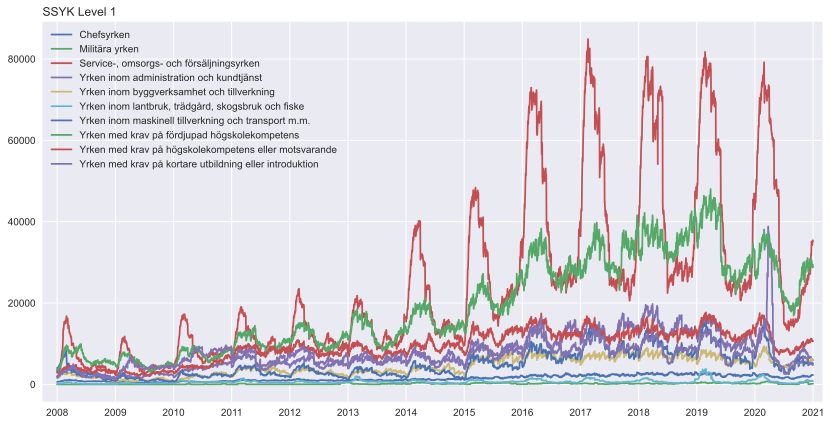

In [112]:
fig = plt.figure(figsize=(14,7))

for cols in range(len(res_1.columns)):
    plt.plot(res_1.index, res_1.iloc[:,cols], label=res_1.columns[cols])
    
plt.xticks(ticks=date_index, labels=date_range)
plt.xlim(datetime(2007,10,1), datetime(2021,3,1))
plt.legend(loc='upper left')
plt.title('SSYK Level 1', loc='left')
#plt.savefig('/Users/Kevin/Desktop/project_dta/figure_results/results.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [113]:
fig = plt.figure(figsize=(14,7))

for cols in range(len(res_2.columns)):
    plt.plot(res_2.index, res_2.iloc[:,cols], label=res_2.columns[cols])
    
plt.xticks(ticks=date_index, labels=date_range)
plt.xlim(datetime(2007,10,1), datetime(2021,3,1))
#plt.legend(loc='upper left')
plt.title('SSYK Level 2', loc='left')
#plt.savefig('/Users/Kevin/Desktop/project_dta/figure_results/results.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### Discussion
- In progress

In [105]:
x = pd.read_csv('/Users/Kevin/Desktop/project_dta/extension_2/results_ssyk2.csv')

In [110]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
x.describe()

Politiker, verkställande direktörer och högre ämbetsmän m.fl.  \
count                                        4749.000000               
mean                                           83.279848               
std                                            49.090749               
min                                            14.000000               
25%                                            46.000000               
50%                                            71.000000               
75%                                           110.000000               
max                                           269.000000               

       Chefer inom ekonomi, personal, marknadsföring och försäljning samt annan administration m.m.  \
count                                        4749.000000                                              
mean                                          475.418193                                              
std                                           234.157236                                              
min                                           112.000000                                              
25%                                           303.000000                                              
50%                                           398.000000                                              
75%                                           685.000000                                              
max                                          1307.000000                                              

       Chefer inom IT, logistik, FoU, fastighetsbolag, bygg- och ingenjörsverksamhet samt tillverkning m.m.  \
count                                        4749.000000                                                      
mean                                          297.680564                                                      
std                                           150.223253                                                      
min                                            56.000000                                                      
25%                                           184.000000                                                      
50%                                           243.000000                                                      
75%                                           422.000000                                                      
max                                           711.000000                                                      

       Chefer inom utbildning  \
count             4749.000000   
mean               153.640977   
std                 71.247165   
min                 37.000000   
25%                103.000000   
50%                138.000000   
75%                192.000000   
max                487.000000   

       Chefer inom hälso- och sjukvård samt annan samhällsservice  \
count                                        4749.000000            
mean                                          296.743736            
std                                           152.456325            
min                                            45.000000            
25%                                           161.000000            
50%                                           286.000000            
75%                                           419.000000            
max                                           746.000000            

       Chefer inom bank, finans och försäkring  \
count                              4749.000000   
mean                                  3.616130   
std                                   3.071638   
min                                   0.000000   
25%                                   1.000000   
50%                                   3.000000   
75%                                   5.000000   
max                                  18.000000   

       Chefer inom övrig servicenäring  \
count            

### Concluding remarks
#### Thank you for examining my project! Pleas contact me if you have any feedback on possible improvement or other comments on the project.

Contact: [kevin.dee.boman@gmail.com](kevin.dee.boman@gmail.com)

#### Future project plans:

   - In a future project, a current labor demand index will be constructed using JobTechDevs API service in combination with ads scraped from supplementary sources that systematically are not posted on platsbanken (The public employment service job ads platform).
   - The index may also be disaggregated by county/city and occupational group using [SSYK classification](https://www.scb.se/dokumentation/klassifikationer-och-standarder/standard-for-svensk-yrkesklassificering-ssyk/) (Swedens official classification system for occupational groups, only available in Swedish). This would extend the use of the index as regional labor demand and labor demand among different occupational groups could be estimated.